# Correct out-of-sample embedding

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from graspologic.simulations import sbm
from graspologic.embed import AdjacencySpectralEmbed as ASE
from graspologic.plot import pairplot, heatmap

import warnings
warnings.filterwarnings('ignore')

In [4]:
def oos_fit(X, y, eig_values):
    """
    Given some latent position matrix X,
    its diagonal eigenvalue matrix D,
    and edge vector y,
    compute the least-squares estimate for the latent position of y.
    """
    pinv = X @ np.diag(1/eig_values)
    return y @ pinv

def test_pseudoinv(X, eig_values):
    # X_hat is U @ np.diag(np.sqrt(D)), 
    # where U is a unitary matrix of eigenvectors and D is a diagonal eigenvalue matrix
    pinv = X @ np.diag(1/eig_values)  # so pinv is A^+.T
    pinv_np = np.linalg.pinv(X.T)

    # same matrix as numpy's pseudoinverse function
    np.allclose(pinv_np, pinv)

    ## moore-penrose conditions:
    print(f"AA^+A = A: {np.allclose(X, X @ pinv.T @ X)}")
    print(f"A^+AA^+ = A^+: {np.allclose(pinv.T, pinv.T @ X @ pinv.T)}")
    print(f"(AA^+)^t = AA^+: {np.allclose((X @ pinv.T).T, X@pinv.T)}")
    print(f"(AA^+)^t = AA^+: {np.allclose((pinv.T@X).T, pinv.T@X)}")
    # so pinv.T is the pseudoinverse of X

# generate matrix (TODO: make it an SBM)
p = np.array([[.9, .1,],
              [.1, .9]])
M = sbm([51, 51], p)

# embed original matrix
a1 = M[0, 1:-1]  # vector for oos vertex z1, top-left
a2 = M[-1, 1:-1]  # vector for oos vertex z2, bottom-right

A = M[1:-1, 1:-1]  # in-sample adjacency matrix
ase = ASE(n_components=2)
ase.fit(A)  # only in-sample
X = ase.latent_left_.copy()  # U @ np.diag(np.sqrt(D))
eig_values = ase.singular_values_.copy()

# make sure hayden's pseudoinverse equation satisfies the moore-penrose equivalence
test_pseudoinv(X, eig_values)

# embed oos node
w1 = oos_fit(X, a1, eig_values)
w2 = oos_fit(X, a2, eig_values)
X_augmented = np.vstack((X, w1, w2))

# test embedding
labels = ["Red"]*50+["Blue"]*50

AA^+A = A: True
A^+AA^+ = A^+: True
(AA^+)^t = AA^+: True
(AA^+)^t = AA^+: True


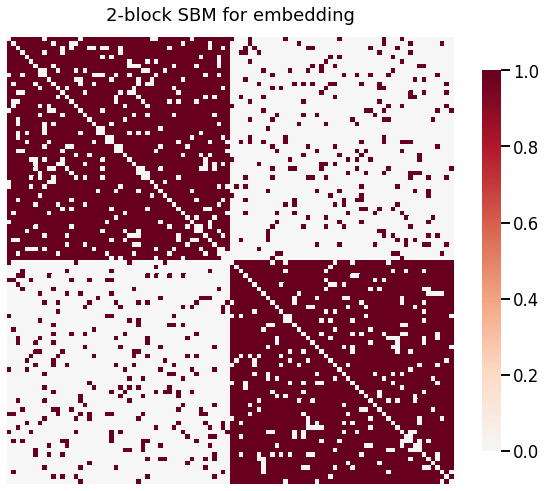

In [5]:
heatmap(A, title="2-block SBM for embedding");
plt.savefig("../figs/SBM.png", dpi=600)

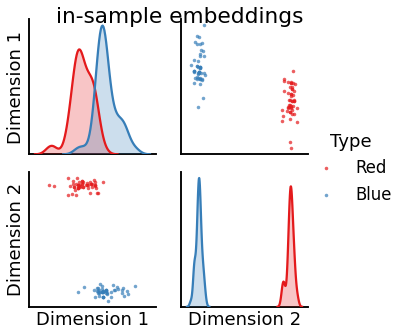

In [6]:
df = pairplot(X, labels=labels, title="in-sample embeddings").data

In [7]:
df

,Type,Dimension 1,Dimension 2
0,Red,0.691041,0.656698
1,Red,0.673708,0.671074
2,Red,0.621434,0.567931
3,Red,0.701476,0.706685
4,Red,0.658864,0.714773
...,...,...,...
95,Blue,0.729728,-0.652908
96,Blue,0.698137,-0.571575
97,Blue,0.728076,-0.654622
98,Blue,0.800331,-0.640420


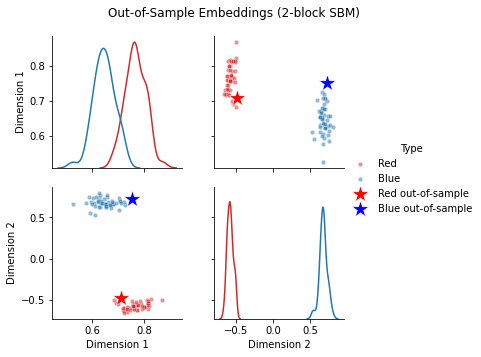

In [9]:
for pt, label in zip([w1, w2], ["Red out-of-sample", "Blue out-of-sample"]):
    data = {"Type": label, "Dimension 1": pt[0], 
            "Dimension 2": pt[1]}
    df = df.append(data, ignore_index=True)
    
g = sns.PairGrid(df, hue="Type",
                 hue_order=["Red", "Blue", "Red out-of-sample", "Blue out-of-sample"],
                 palette=["tab:red", "tab:blue", "r", "b"],
                 hue_kws={"s": [20, 20, 300, 300],
                          "marker": ["o", "o", "*", "*"],
                          "alpha": [.5, .5, 1, 1],
                         },
                 layout_pad=1)

g.map_offdiag(plt.scatter, linewidth=.5, edgecolor="w")
g.map_diag(sns.kdeplot);
g.add_legend();
plt.subplots_adjust(top=0.9);
g.fig.suptitle("Out-of-Sample Embeddings (2-block SBM)");

### try matrix of oos values

### is embedding from matrix of oos values the same as doing them separately?

In [22]:
oos_nodes = np.row_stack((a1, a2))

X_aug_2 = oos_fit(X, oos_nodes, eig_values)

# they are the same
print(X_aug_2, "\n")
print(X_augmented[-2:])

[[ 0.70964065 -0.47677807]
 [ 0.75054304  0.7284551 ]] 

[[ 0.70964065 -0.47677807]
 [ 0.75054304  0.7284551 ]]
